## Goal: investigate how the rate of virus spread varies geographically based on US county-level data

Basic assumptions:

-Want to fit an exponential curve to the infection growth. The growth rate may vary geographically with different features such as population density, ...

-Because tests are not widely available, the number of infected cases is hard to track. However, death cases are well documented and trackable. Assuming the mortality rate is fixed and same for all counties, death counts are proportional to the number of infected cases and share the same exponential growth coefficient. Thus we use death count data in our analysis.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# read in data that includes county-level population density and time-series death counts 
df_density = pd.read_csv("/Users/yujiazhang/Downloads/covid_county_data (1).csv")
df_density.head()

,Unnamed: 0,date,county_name,long_county_name,state,pop_density,population,death_count
0,0,1/22/20,Autauga,"Autauga, Alabama, US",Alabama,91.8,55869,0
1,1,1/22/20,Baldwin,"Baldwin, Alabama, US",Alabama,114.6,223234,0
2,2,1/22/20,Barbour,"Barbour, Alabama, US",Alabama,31.0,24686,0
3,3,1/22/20,Bibb,"Bibb, Alabama, US",Alabama,36.8,22394,0
4,4,1/22/20,Blount,"Blount, Alabama, US",Alabama,88.9,57826,0


In [12]:
# Get county names; 3140 counties in total
# Moreover, we need long county names because some county names appear more than once 
# (e.g. Bibb, Alabama and Bibb, Georgia)

county_names = df_density['county_name'][0:3140]
long_county_names = df_density['long_county_name'][0:3140]

# Create county_reg dataframe for regression
county_reg = pd.DataFrame({'county name' : long_county_names})
county_reg['state'] = df_density['state'][0:3140]

# get population density of each county and store in regression df; this will be our covariate
# unit: number of people / square mile

pop_density = df_density['pop_density'][0:3140]
county_reg['pop_density'] = pop_density


county_reg.head()

,county name,state,pop_density
0,"Autauga, Alabama, US",Alabama,91.8
1,"Baldwin, Alabama, US",Alabama,114.6
2,"Barbour, Alabama, US",Alabama,31.0
3,"Bibb, Alabama, US",Alabama,36.8
4,"Blount, Alabama, US",Alabama,88.9


### First: estimate the exponential growth rate before social distancing was widely adopted

In [78]:
# specify a cutoff date, roughly ~ 2 weeks after social distancing measures are enforced
# we only consider data before the cutoff date because those are representative of the 
# infection trends without distancing

cutoffdate_str = '4/5/20'


In [13]:
# dates at which stay-at-home orders went into effect for different states
# create dictionary of (state, SDstartdate)

SDstart = dict.fromkeys(county_reg['state'].unique(), '4/13/20')

SDstart.update(dict.fromkeys(['California'], '3/19/20'))
SDstart.update(dict.fromkeys(['Illinois', 'New Jersey'], '3/21/20'))
SDstart.update(dict.fromkeys(['New York'], '3/22/20'))
SDstart.update(dict.fromkeys(['Connecticut','Louisiana','Ohio','Oregon','Washington'], '3/23/20'))
SDstart.update(dict.fromkeys(['Delaware', 'Indiana', 'Massachusetts', 'Michigan', 'New Mexico', 'West Virginia'], '3/24/20'))
SDstart.update(dict.fromkeys(['Hawaii', 'Idaho', 'Wisconsin', 'Vermont'], '3/25/20'))
SDstart.update(dict.fromkeys(['Colorado', 'Kentucky'], '3/26/20'))
SDstart.update(dict.fromkeys(['Minnesota', 'New Hampshire'], '3/27/20'))
SDstart.update(dict.fromkeys(['Alaska','Montana','Rhode Island'], '3/28/20'))
SDstart.update(dict.fromkeys(['Kansas','Maryland','North Carolina','Virginia'], '3/30/20'))
SDstart.update(dict.fromkeys(['Arizona','Tennessee'], '3/31/20'))
SDstart.update(dict.fromkeys(['District of Columbia', 'Nevada','Pennsylvania'], '4/1/20'))
SDstart.update(dict.fromkeys(['Maine','Texas'], '4/2/20'))
SDstart.update(dict.fromkeys(['Georgia', 'Florida', 'Mississippi'], '4/3/20'))
SDstart.update(dict.fromkeys(['Alabama'], '4/4/20'))
SDstart.update(dict.fromkeys(['Missouri'], '4/6/20'))
SDstart.update(dict.fromkeys(['South Carolina'], '4/7/20'))

In [14]:
# now we compute the PRE-social-distancing log(alpha) for each county
# by averaging log(deaths(t+1)/deaths(t)) over the days from 1st death to the cutoff date

valid = np.zeros(3140)
mean = np.zeros(3140)
sd = np.zeros(3140)

for i in range(len(county_names)):
    
    #print(i)
    
    # for each county, start computing after the occurrence of the first death
    county = df_density[df_density['long_county_name'] == long_county_names[i]]
    
    cutoffdate = np.where(county['date'] == SDstart[county['state'].values[0]])[0][0] + 14
    #print(cutoffdate)
    
    # find the time of the first death
    if any(county['death_count']>=1):
        first_death_time = np.min(np.where(county['death_count']>=1))
    
        if first_death_time >= cutoffdate:
            # if the first death of the county occurred after the last day of interest
            # we do not include this county in the regression
        
            valid[i] = False
        
        else:
            # if the first death occurred before the last day of interest
            # include it in the regression, and estimate difference-in-log(deaths) value
            
            cutoffdate_ceil = np.min([len(df_density['date'].unique()), cutoffdate])
            
            valid_death_counts = county['death_count'][first_death_time : cutoffdate_ceil]
            
            if len(valid_death_counts)==1:
                valid[i] = False
            else:
                valid[i] = True
            
                difflog = []
                for j in range(1, len(valid_death_counts)):
                    difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))

                x = np.ones(len(difflog))
                mod = sm.OLS(difflog, x, missing='drop')
                res = mod.fit()

                mean[i] = res.params[0]
                sd[i] = res.bse[0]
            
    else:
        valid[i] = False

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
county_reg['mean_PRE_adjusted'] = mean
county_reg['sd_PRE_adjusted'] = sd
county_reg.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted
0,"Autauga, Alabama, US",Alabama,91.8,0.0,0.0
1,"Baldwin, Alabama, US",Alabama,114.6,0.0,0.0
2,"Barbour, Alabama, US",Alabama,31.0,0.0,0.0
3,"Bibb, Alabama, US",Alabama,36.8,0.0,0.0
4,"Blount, Alabama, US",Alabama,88.9,0.0,0.0


In [16]:
county_reg_valid = county_reg[valid==1]
county_reg_valid.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted
0,"Autauga, Alabama, US",Alabama,91.8,0.000000,0.000000
1,"Baldwin, Alabama, US",Alabama,114.6,0.000000,0.000000
8,"Chambers, Alabama, US",Alabama,57.4,0.065389,0.026118
16,"Colbert, Alabama, US",Alabama,91.8,0.000000,0.000000
21,"Cullman, Alabama, US",Alabama,109.4,0.000000,0.000000


Text(0.5, 1.0, 'Adjusted county-wise PRE social distancing log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

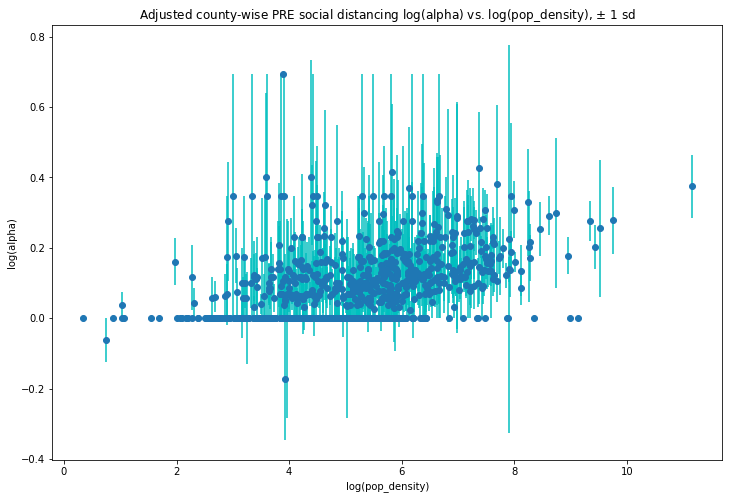

In [22]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_valid['pop_density']
y = county_reg_valid['mean_PRE_adjusted']
yerr = county_reg_valid['sd_PRE_adjusted']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted county-wise PRE social distancing log(alpha) vs. log(pop_density), $\pm$ 1 sd")

### Next: weighted linear regression

The next step is to do a weighted linear regression, with weights inversely proportional to variance. As we can see from the graph above, many data points don't have an error bar around them - this corresponds to zero variance and will result in a weight of infinity. 

As a first try, we simply drop the points with zero variance. This is not unreasonable because these points are counties with very few deaths that didn't grow over time in our examined time window (usually 1 case throughout) or counties with only 1 or 2 observations (days) from the first death to 4/5. Either way, they are not very informative of the virus's spreading behavior, so we drop them for now.

In [19]:
# Try: drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0 = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0)

402

In [20]:
# WLS on remaining 381 terms

X_wls_0 = np.log(np.delete(x.values, drop0))
y_wls_0 = np.delete(y.values, drop0)
yerr_wls_0 = np.delete(yerr.values, drop0)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            WLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     2020.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          7.62e-180
Time:                        12:46:33   Log-Likelihood:                 630.07
No. Observations:                 513   AIC:                            -1258.
Df Residuals:                     512   BIC:                            -1254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0190      0.000     44.944      0.0

Text(0.5, 1.0, 'Adjusted PRE-social-distancing log(alpha) vs log(pop_density)')

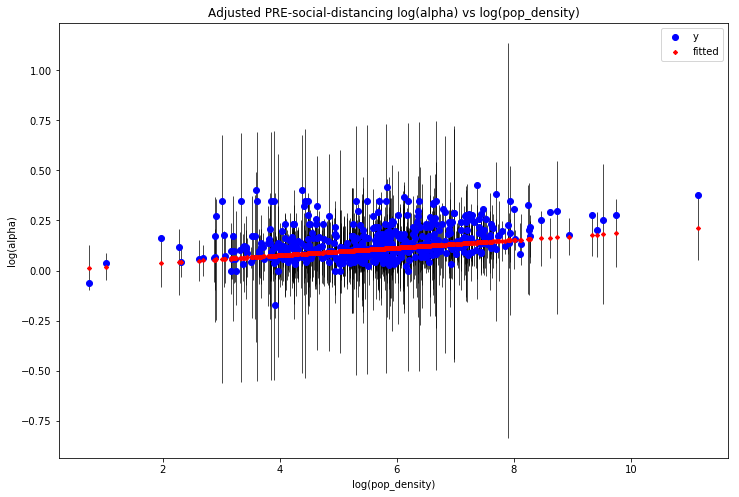

In [21]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted PRE-social-distancing log(alpha) vs log(pop_density)")


In [ ]:
# the next thing to try: smooth out the death counts over a window when running 
# individual regressions for counties
# perhaps this will eliminate the 0-variance issues


# or: filter by death counts?

### Furthermore: we are interested in estimating the growth rate after social distancing measures were widely adopted
we adjust this for the different times that each state's stay-at-home order came into effect

In [23]:
# run the same regression for POST-social-distancing log(alpha)
# by averaging log(deaths(t+1)/deaths(t)) over the days after 4/5

valid_POST = np.zeros(3140)
mean_POST = np.zeros(3140)
sd_POST = np.zeros(3140)

for i in range(len(county_names)):
    #print(i)
    
    county = df_density[df_density['long_county_name'] == long_county_names[i]] 
    cutoffdate = np.where(county['date'] == SDstart[county['state'].values[0]])[0][0] + 14
    
    # if there is a death, compute mean starting from max(cutoffdate, first death)
    # else, set valid_POST to false
    
    if cutoffdate >= len(df_density['date'].unique()):
        # the county has not entered social distancing + 14 days before the last recorded day
        valid_POST[i] = False
        
    else:
    
        if any(county['death_count'] >= 1):
        
            first_death_time = np.min(np.where(county['death_count']>=1))
            start = np.max([first_death_time, cutoffdate])
            valid_death_counts = county['death_count'][start:]

            if len(valid_death_counts)==1:
                valid_POST[i] = False
                mean_POST[i] = 0
                sd_POST[i] = 0     
            else:
                # to rule out nonmonotonic death counts (data error)
                if any(valid_death_counts==0):
                    valid_POST[i] = False
                else:
                    valid_POST[i] = True
                    difflog = []
                    for j in range(1, len(valid_death_counts)):
                        difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))

                    x = np.ones(len(difflog))
                    mod = sm.OLS(difflog, x, missing='drop')
                    res = mod.fit()

                    mean_POST[i] = res.params[0]
                    sd_POST[i] = res.bse[0]


In [24]:
# store in county_reg dataframe and extract valid rows
county_reg['mean_POST_adjusted'] = mean_POST
county_reg['sd_POST_adjusted'] = sd_POST

county_reg_POST_valid = county_reg[valid_POST==1]

In [25]:
county_reg_POST_valid.shape

(484, 7)

Text(0.5, 1.0, 'Adjusted county-wise post-soc-distancing log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

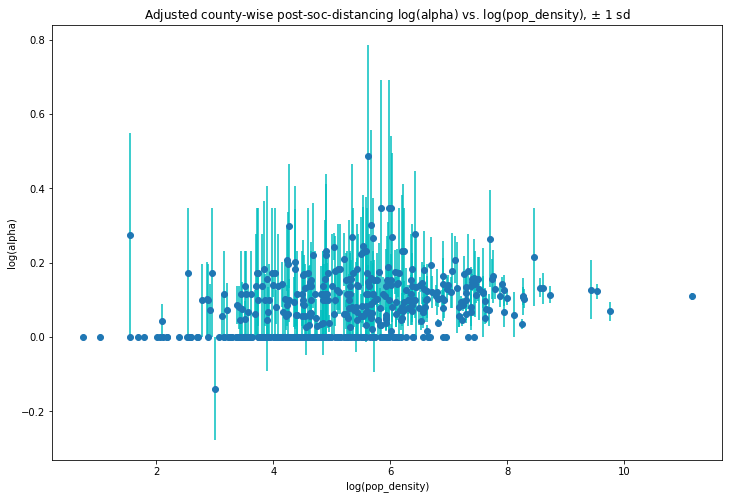

In [26]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_POST_valid['pop_density']
y = county_reg_POST_valid['mean_POST_adjusted']
yerr = county_reg_POST_valid['sd_POST_adjusted']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted county-wise post-soc-distancing log(alpha) vs. log(pop_density), $\pm$ 1 sd")

In [27]:
# Drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0_POST = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0_POST)

193

In [28]:
# WLS on remaining 585 terms

X_wls_0 = np.log(np.delete(x.values, drop0_POST))
y_wls_0 = np.delete(y.values, drop0_POST)
yerr_wls_0 = np.delete(yerr.values, drop0_POST)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            WLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     947.7
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           2.21e-93
Time:                        12:51:21   Log-Likelihood:                 356.97
No. Observations:                 291   AIC:                            -711.9
Df Residuals:                     290   BIC:                            -708.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0116      0.000     30.785      0.0

Text(0.5, 1.0, 'Adjusted POST-social-distancing log(alpha) vs log(pop_density)')

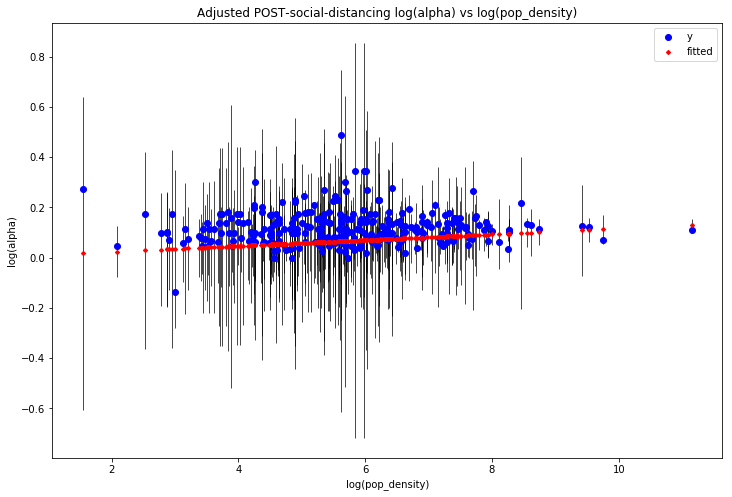

In [29]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted POST-social-distancing log(alpha) vs log(pop_density)")

In [179]:
county_reg.to_csv("/Users/yujiazhang/Downloads/logalpha_adjusted.csv")

## Question: How much effect did social distancing have on the transmission rate?

In [27]:
change_ind = []
for i in range(3140):
    if valid[i]==1 and valid_POST[i]==1:
        change_ind.append(i)
        
#print(change_ind)
change = county_reg.iloc[change_ind]
changeNY = change[change['state'] =='New York']
change.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted,mean_PRE,sd_PRE,mean_POST_adjusted,sd_POST_adjusted
69,"Anchorage,Alaska,US",Alaska,171.2,0.106638,0.106638,0.106638,0.106638,0.000000,0.000000
74,"Fairbanks North Star,Alaska,US",Alaska,13.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
185,"Alameda, California, US",California,2043.6,0.216212,0.100578,0.216212,0.100578,0.096005,0.037479
191,"Contra Costa, California, US",California,1465.2,0.091551,0.064213,0.091551,0.064213,0.118117,0.046363
199,"Kern, California, US",California,103.3,0.000000,0.000000,0.000000,0.000000,0.099874,0.069748


In [29]:
changeNY[changeNY['mean_POST_adjusted']>changeNY['mean_PRE_adjusted']]

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted,mean_PRE,sd_PRE,mean_POST_adjusted,sd_POST_adjusted
1833,"Chautauqua, New York, US",New York,127.2,0.000000,0.000000,0.000000,0.000000,0.137327,0.093921
1837,"Columbia, New York, US",New York,99.4,0.099021,0.099021,0.099021,0.099021,0.137327,0.053127
1839,"Delaware, New York, US",New York,33.3,0.000000,NaN,0.000000,NaN,0.137327,0.093921
1852,"Livingston, New York, US",New York,103.5,0.000000,0.000000,0.000000,0.000000,0.137327,0.093921
1859,"Oneida, New York, US",New York,193.7,0.000000,0.000000,0.000000,0.000000,0.050683,0.050683
1872,"Saratoga, New York, US",New York,271.1,0.000000,0.000000,0.000000,0.000000,0.173287,0.173287
1882,"Ulster, New York, US",New York,162.3,0.095894,0.095894,0.095894,0.095894,0.126450,0.052497


Text(0.5, 1.0, 'NY counties change in log(alpha) before and after 4/5 \n (for counties with >0 deaths before 4/5)')

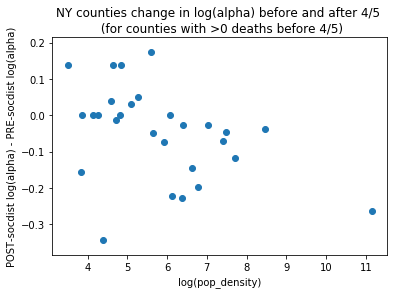

In [28]:
plt.scatter(np.log(changeNY['pop_density']), changeNY['mean_POST_adjusted']-changeNY['mean_PRE_adjusted'])
plt.xlabel('log(pop_density)')
plt.ylabel('POST-socdist log(alpha) - PRE-socdist log(alpha)')
plt.title('NY counties change in log(alpha) before and after 4/5 \n (for counties with >0 deaths before 4/5)')

Text(0.5, 1.0, 'Change in log(alpha) before and after social distancing \n (adjusted for different states)')

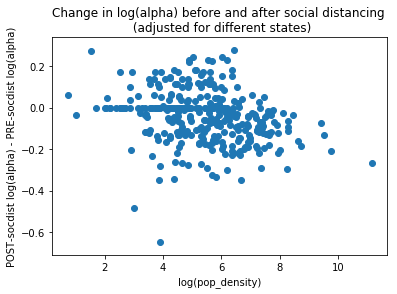

In [30]:
plt.scatter(np.log(change['pop_density']), change['mean_POST_adjusted']-change['mean_PRE_adjusted'])
plt.xlabel('log(pop_density)')
plt.ylabel('POST-socdist log(alpha) - PRE-socdist log(alpha)')
plt.title('Change in log(alpha) before and after social distancing \n (adjusted for different states)')



Text(0, 0.5, 'number of instances')

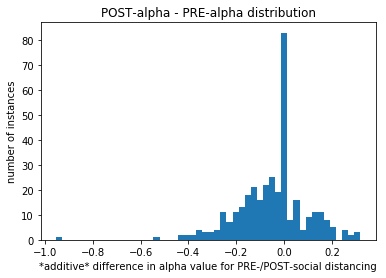

In [234]:
plt.hist(np.exp(change['mean_POST_adjusted']) - np.exp(change['mean_PRE_adjusted']), bins=50)
plt.title('POST-alpha - PRE-alpha distribution')
plt.xlabel('*additive* difference in alpha value for PRE-/POST-social distancing')
plt.ylabel('number of instances')

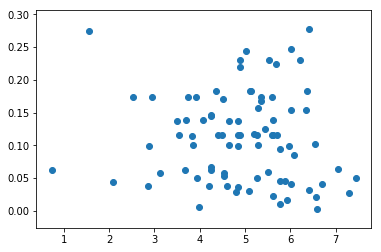

In [185]:
inc = change[change['mean_POST_adjusted']>change['mean_PRE_adjusted']]
plt.scatter(np.log(inc['pop_density']), inc['mean_POST_adjusted'] - inc['mean_PRE_adjusted'])

## Question / Illustration: How are the county-level population densities distributed in terms of the severity of the virus?

Text(0, 0.5, 'Number of instances')

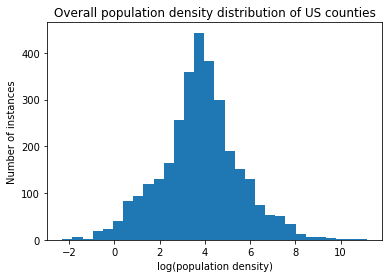

In [362]:
# overall population density distribution
# peak around 4

plt.hist(np.log(pop_density+0.1), bins=30)
plt.title('Overall population density distribution of US counties')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

Text(0, 0.5, 'Number of instances')

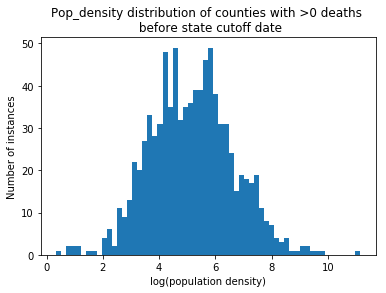

In [36]:
# distribution of pop_density of counties with >0 deaths before 4/5
# we can see it is almost bimodal with a larger peak shifting towards 6

plt.hist(np.log(pop_density[np.where(valid==1)[0]]),bins=60)
plt.title('Pop_density distribution of counties with >0 deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


Text(0, 0.5, 'Number of instances')

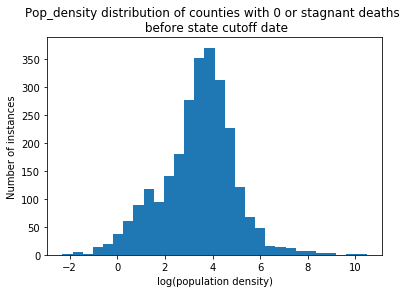

In [37]:
# population density distribution for "stagnant" counties with no or ungrowing deaths
# the distribution is still centered around 4, similar to overall US shape

stagnant = np.where(mean <= 0)[0]

plt.hist(np.log(pop_density[stagnant]+0.1), bins=30)
plt.title('Pop_density distribution of counties with 0 or stagnant deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

In [39]:
len(stagnant)

2611

Text(0, 0.5, 'Number of instances')

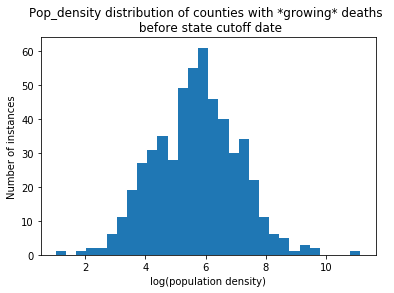

In [38]:
# For counties whose death counts are growing (log(alpha)>0):
# their log densities are concentrated around 6, much higher than the US average

plt.hist(np.log(np.delete(pop_density.values, stagnant)), bins=30)
plt.title('Pop_density distribution of counties with *growing* deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

In [40]:
3140-2611

529